In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.cm as cm

# 獲取當前工作目錄
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
version3_path = os.path.join(parent_dir, "Version3")

# 暫時將工作目錄切換到 Version3
os.chdir(version3_path)

from utils.utils_v3 import *
from utils.plots import *
from utils.preprocess import split_death_injury, describe_process_other, process_age_speed

try:
    myfont = FontProperties(fname=r"/System/Library/Fonts/PingFang.ttc")
    sns.set(style="whitegrid", font=myfont.get_name())
except Exception as e:
    print(e)

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

dataA2 = pd.read_csv("./Data/A2.csv", low_memory=False)
dataA1 = pd.read_csv("./Data/A1.csv")

[Errno 2] No such file or directory: 'C:\\System\\Library\\Fonts\\PingFang.ttc'


In [2]:
select_lst = [
    # 月份是為了篩選每個月2萬筆
    '發生月份',

    '天候名稱', '光線名稱', 
    '道路類別-第1當事者-名稱', '速限-第1當事者', 
    '路面狀況-路面鋪裝名稱', '路面狀況-路面狀態名稱', '路面狀況-路面缺陷名稱',
    '道路障礙-障礙物名稱', '道路障礙-視距品質名稱', '道路障礙-視距名稱',
    '號誌-號誌種類名稱', '號誌-號誌動作名稱',
    '車道劃分設施-分道設施-快車道或一般車道間名稱', '車道劃分設施-分道設施-快慢車道間名稱', '車道劃分設施-分道設施-路面邊線名稱',
    '當事者屬-性-別名稱', '當事者事故發生時年齡',
    '保護裝備名稱', '行動電話或電腦或其他相類功能裝置名稱',
    '肇事逃逸類別名稱-是否肇逃',
    '死亡受傷人數',

    # 大類別
    '道路型態大類別名稱', '事故位置大類別名稱',
    '車道劃分設施-分向設施大類別名稱',
    '事故類型及型態大類別名稱', '當事者區分-類別-大類別名稱-車種', '當事者行動狀態大類別名稱',
    '車輛撞擊部位大類別名稱-最初', '車輛撞擊部位大類別名稱-其他',

    # 兩個欄位只有兩個觀察值不同
    '肇因研判大類別名稱-主要',
    # '肇因研判大類別名稱-個別',
    
    # 子類別
    '道路型態子類別名稱', '事故位置子類別名稱', '事故類型及型態子類別名稱', '肇因研判子類別名稱-主要',
    '當事者區分-類別-子類別名稱-車種', '當事者行動狀態子類別名稱', '車輛撞擊部位子類別名稱-最初',
    '車輛撞擊部位子類別名稱-其他', '肇因研判子類別名稱-個別',
]

def preprocess(input_data, select_lst):
    # 篩選到第一個順位，因為注重的是單次事故的情況
    sample_data = input_data[input_data['當事者順位'] == 1].reset_index(drop=True, inplace=False)
    sample_data = sample_data[sample_data['發生月份'] < 11]
    dataA = sample_data[select_lst]
    
    # 將資料分出死亡和受傷，合併到原本的資料後去除多餘的死亡受傷人數
    death_injury_data = split_death_injury(dataA['死亡受傷人數'])
    dist_df = pd.concat([dataA, death_injury_data], axis=1)

    # 補齊缺失值
    dist_df[select_lst] = dist_df[select_lst].fillna('未紀錄')

    # 速限範圍
    dist_df = dist_df[(dist_df['速限-第1當事者'] < 200) &
                      (dist_df['當事者事故發生時年齡'] < 100) &
                      (dist_df['當事者事故發生時年齡'] > 0)]

    dist_df.drop(columns=['死亡受傷人數'], inplace=True)
    
    return dist_df

dist_dfA1 = preprocess(dataA1, select_lst)
dist_dfA2 = preprocess(dataA2, select_lst)

In [3]:
rbind_data = describe_process_other(dist_dfA1, dist_dfA2, en=True)

[]


In [4]:
for i in rbind_data.columns:
    print(rbind_data[i].value_counts())
    print('-'*100)

晴      253017
陰       31304
雨       29092
風         404
霧或煙        98
風沙         17
雪           1
Name: 天候名稱, dtype: int64
----------------------------------------------------------------------------------------------------
有照明未開啟或故障    138459
有照明且開啟        99685
無照明           75789
Name: 光線名稱, dtype: int64
----------------------------------------------------------------------------------------------------
市區道路      248164
村里道路       32563
其他         10334
縣道          7668
省道          6084
鄉道          5144
國道          2892
專用道路         806
快速(公)道       278
Name: 道路類別-第1當事者-名稱, dtype: int64
----------------------------------------------------------------------------------------------------
50.0     201595
30.0      45488
40.0      42008
60.0      12394
70.0       3686
0.0        3086
110.0      1089
100.0      1012
20.0        773
90.0        659
10.0        550
25.0        408
80.0        402
5.0         271
15.0        182
1.0          90
35.0         70
3.0          43
45.0         2

In [5]:
death_rate_summary = (
    rbind_data.groupby("事故類型及型態子類別名稱")
    .agg(
        總事故數=("死亡", "count"),  # 計算該類別的總事故數
        死亡事故數=("死亡", "sum")   # 計算該類別的死亡事故數
    )
    .assign(死亡比例=lambda x: x["死亡事故數"] / x["總事故數"])  # 計算死亡率
    .reset_index()  # 重置索引，轉回普通欄位
)
death_rate_summary = death_rate_summary[death_rate_summary["總事故數"] > 300]
death_rate_summary.sort_values("死亡比例", ascending=False)

,事故類型及型態子類別名稱,總事故數,死亡事故數,死亡比例
20,撞電桿,1396,75,0.053725
19,撞路樹,496,25,0.050403
18,撞護欄(樁),2025,73,0.036049
12,撞交通島,950,34,0.035789
24,衝出路外,1610,56,0.034783
15,撞建築物,329,11,0.033435
17,撞號誌、標誌桿,783,23,0.029374
23,穿越道路中,7166,121,0.016885
0,佇立路邊(外),312,5,0.016026
10,對撞,2632,37,0.014058


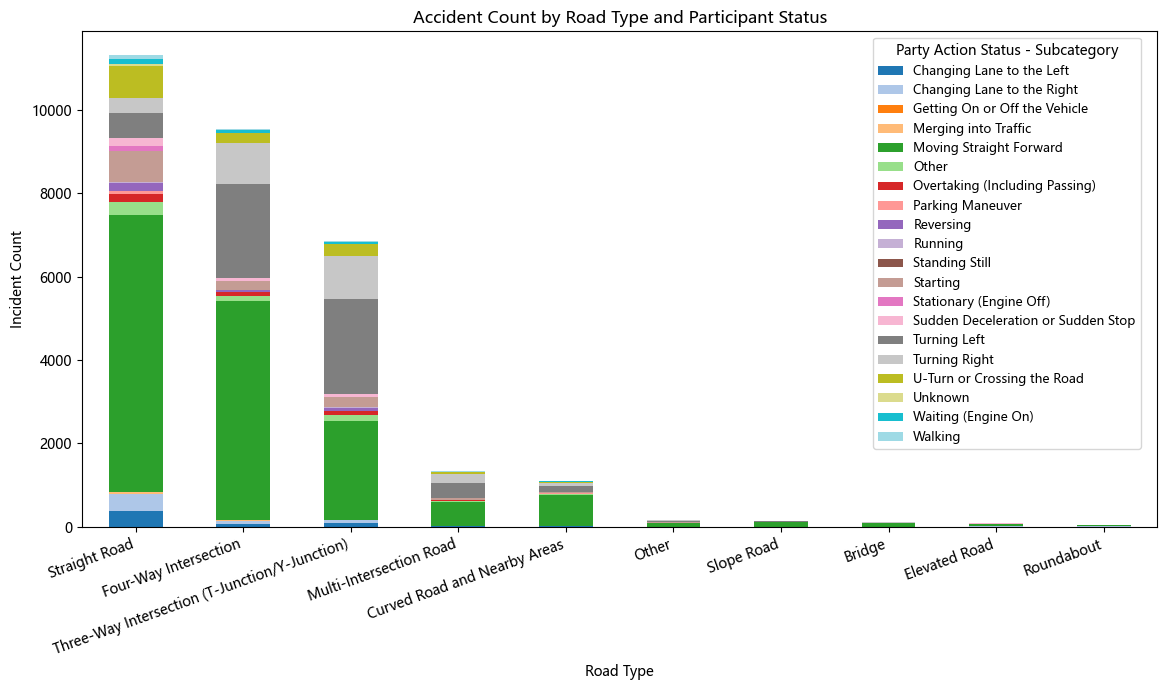

In [4]:
choose = "Party Action Status - Subcategory"

f_rbind_data = rbind_data[rbind_data['Vehicle Impact Area - Other - Subcategory'] != 'Not Recorded']
cross_tab = pd.crosstab(
    f_rbind_data["Road Category - Subcategory"],
    f_rbind_data[choose]
)

cross_tab = cross_tab.assign(total=cross_tab.sum(axis=1)).sort_values(by="total", ascending=False).drop(columns=["total"]).head(10)

num_categories = cross_tab.columns.size

colors = cm.get_cmap('tab20', num_categories)

ax = cross_tab.plot(kind="bar", stacked=True, figsize=(12, 7), color=[colors(i) for i in range(num_categories)])
plt.title("Accident Count by Road Type and Participant Status")
plt.xlabel("Road Type")
plt.ylabel("Incident Count")
plt.legend(title=choose, bbox_to_anchor=(0.73, 1), loc="upper left", fontsize=9)
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
choose = "當事者行動狀態子類別名稱"

f_rbind_data = rbind_data[rbind_data['車輛撞擊部位子類別名稱-其他'] != '未紀錄']
cross_tab = pd.crosstab(
    f_rbind_data["道路型態子類別名稱"],
    f_rbind_data[choose]
)

# 排序並刪除臨時總數欄位
cross_tab = cross_tab.assign(總數=cross_tab.sum(axis=1)).sort_values(by="總數", ascending=False).drop(columns=["總數"]).head(10)

# 獲取類別數量
num_categories = cross_tab.columns.size

# 自定義顏色調色盤
colors = cm.get_cmap('tab20', num_categories)  # 使用 'tab20' 調色盤，支持最多 20 種顏色

# 繪製堆疊柱狀圖
ax = cross_tab.plot(kind="bar", stacked=True, figsize=(12, 6), color=[colors(i) for i in range(num_categories)])
plt.title("當事者狀態對道路型態事故件數")
plt.xlabel("道路型態種類")
plt.ylabel("件數")
plt.legend(title=choose, bbox_to_anchor=(0.82, 1), loc="upper left", fontsize=9)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_16712\1777269285.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


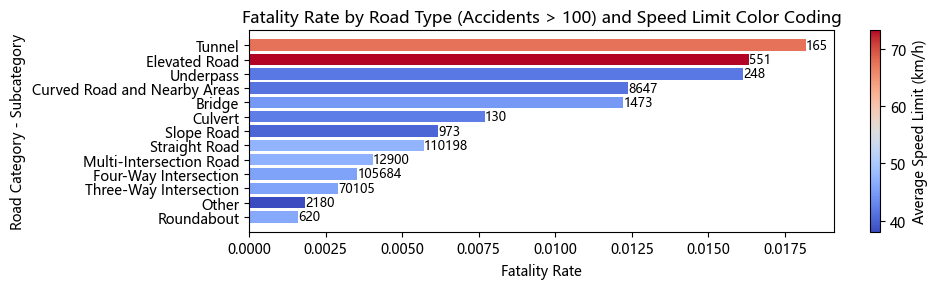

In [ ]:
summary = (
    rbind_data
    .groupby("Road Category - Subcategory")
    .agg(
        Total_Accidents=("死亡", "count"),
        Fatal_Accidents=("死亡", "sum"),
        Average_Speed_Limit=("Speed Limit - First Party", "mean")
    )
    .assign(Fatality_Rate=lambda x: x["Fatal_Accidents"] / x["Total_Accidents"])
    .reset_index()
)

# Filter for total accidents greater than 100 and sort by fatality rate
summary = summary[summary["Total_Accidents"] > 100].sort_values(by="Fatality_Rate", ascending=True)

# Assign colors: based on average speed limit (normalized speed limit value)
norm = plt.Normalize(summary["Average_Speed_Limit"].min(), summary["Average_Speed_Limit"].max())
colors = plt.cm.coolwarm(norm(summary["Average_Speed_Limit"]))

# Plot bar chart
plt.figure(figsize=(10, 3))
bars = plt.barh(summary["Road Category - Subcategory"], summary["Fatality_Rate"], color=colors)

# Add total accidents as labels
for bar, total in zip(bars, summary["Total_Accidents"]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f"{total}", va="center", fontsize=9)

# Add color bar to show the speed limit range
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
cbar = plt.colorbar(sm)
cbar.set_label("Average Speed Limit (km/h)")

plt.title("Fatality Rate by Road Type (Accidents > 100) and Speed Limit Color Coding")
plt.xlabel("Fatality Rate")
plt.ylabel("Road Category - Subcategory")
plt.tight_layout()
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_28740\3004254187.py:32: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


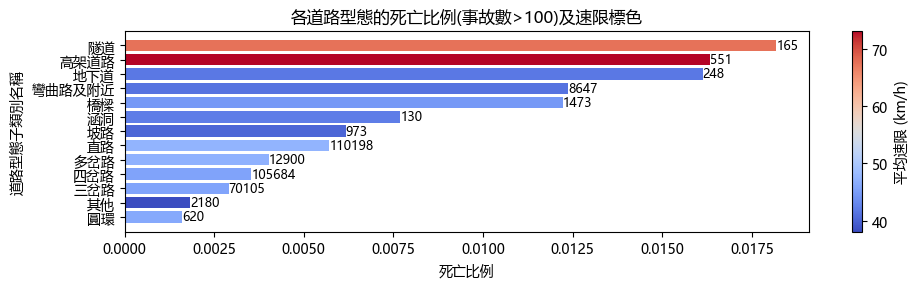

In [ ]:
summary = (
    rbind_data
    .groupby("道路型態子類別名稱")
    .agg(
        總事故數=("死亡", "count"),
        死亡事故數=("死亡", "sum"),
        平均速限=("速限-第1當事者", "mean")
    )
    .assign(死亡比例=lambda x: x["死亡事故數"] / x["總事故數"])
    .reset_index()
)

# 篩選總事故數大於 1 並按死亡比例排序
summary = summary[summary["總事故數"] > 100].sort_values(by="死亡比例", ascending=True)

# 分配顏色：根據平均速限分配顏色（標準化速限值）
norm = plt.Normalize(summary["平均速限"].min(), summary["平均速限"].max())
colors = plt.cm.coolwarm(norm(summary["平均速限"]))

# 繪製條形圖
plt.figure(figsize=(10, 3))
bars = plt.barh(summary["道路型態子類別名稱"], summary["死亡比例"], color=colors)

# 添加總事故數作為標籤
for bar, total in zip(bars, summary["總事故數"]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f"{total}", va="center", fontsize=9)

# 添加顏色條（Colorbar）以顯示速限範圍
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
cbar = plt.colorbar(sm)
cbar.set_label("平均速限 (km/h)")

plt.title("各道路型態的死亡比例(事故數>100)及速限標色")
plt.xlabel("死亡比例")
plt.ylabel("道路型態子類別名稱")
plt.tight_layout()
plt.show()

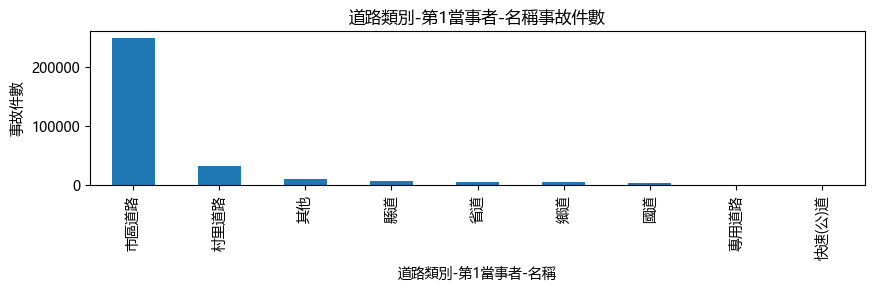

In [10]:
road_quality_counts = rbind_data["道路類別-第1當事者-名稱"].value_counts()
road_quality_counts.sort_values(ascending=False).plot(kind="bar", figsize=(10, 2))
plt.title("道路類別-第1當事者-名稱事故件數")
plt.xlabel("道路類別-第1當事者-名稱")
plt.ylabel("事故件數")
plt.xticks()
plt.show()



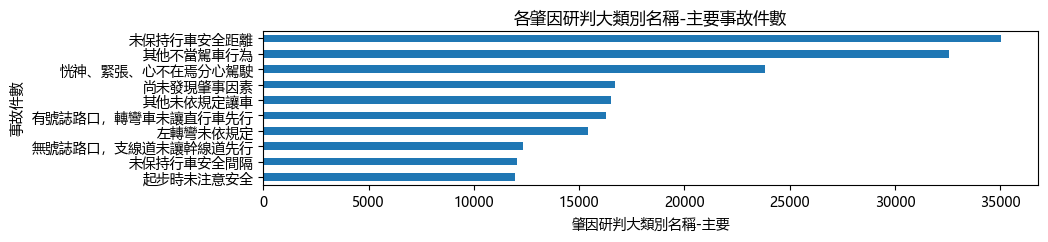

In [11]:
cause_counts = rbind_data["肇因研判子類別名稱-個別"].value_counts().head(10)
cause_counts.sort_values(ascending=True).plot(kind="barh", figsize=(10, 2))
plt.title("各肇因研判大類別名稱-主要事故件數")
plt.xlabel("肇因研判大類別名稱-主要")
plt.ylabel("事故件數")
plt.xticks()
plt.show()


In [ ]:
rbind_data["縣市"] = rbind_data["發生地點"].str[:3]

location_counts = rbind_data["縣市"].value_counts()

location_counts.sort_values(ascending=True).plot(kind="barh", figsize=(10, 6))
plt.title("各縣市事故件數")
plt.xlabel("縣市")
plt.ylabel("事故件數")
plt.xticks(rotation=45)
plt.show()

In [38]:
import folium
from folium.plugins import HeatMap

heat_data  = rbind_data[["緯度", "經度"]].dropna().values.tolist()

map_taiwan = folium.Map(location=[23.5, 121], zoom_start=7)

HeatMap(heat_data, 
        radius=10,
        blur=15,
        ).add_to(map_taiwan)

map_taiwan.save("traffic_heatmap.html")

In [49]:
from scipy.stats import gaussian_kde

coords = rbind_data[["緯度", "經度"]].dropna().values.T

# 計算 KDE
kde = gaussian_kde(coords)
x_min, x_max = coords[1].min() - 0.01, coords[1].max() + 0.01  # 經度範圍
y_min, y_max = coords[0].min() - 0.01, coords[0].max() + 0.01  # 緯度範圍
x, y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]  # 生成網格
positions = np.vstack([y.ravel(), x.ravel()])  # KDE 需要緯度在前，經度在後
density = kde(positions).reshape(x.shape)  # KDE 計算密度

# 將 KDE 結果添加到地圖
map_taiwan = folium.Map(location=[23.5, 121], zoom_start=7)

# 將 KDE 結果標準化
density = (density - density.min()) / (density.max() - density.min())

# 將密度轉為 folium 格式
for i in range(density.shape[0]):
    for j in range(density.shape[1]):
        if density[i, j] > 0.01:  # 過濾較低的密度值
            folium.CircleMarker(
                location=[y[i, j], x[i, j]],
                radius=5,
                weight=0,
                fill=True,
                fill_opacity=density[i, j],
                fill_color="red"
            ).add_to(map_taiwan)

# 儲存結果
map_taiwan.save("traffic_kde_map.html")